In [1]:
from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp
from astropy.coordinates import SkyCoord, Galactocentric


import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)
from functools import partial

from streamsculptor import potential
from streamsculptor import JaxCoords as jc

import interpax

from astropy.constants import G


#### Radial velocity dispersion from the spherical Jean's equation (assuming constant $\beta$)

$$\sigma_r^2 = \frac{r^{-2\beta}}{\rho(r)} \int\limits_{r}^{\infty} dr^\prime r^{\prime{2\beta} } \rho(r^\prime) \frac{d\Phi}{dr}$$


In [2]:
from jax.scipy.integrate import trapezoid

@partial(jax.jit, static_argnums=(2,))
def get_sigma_r(r, beta, pot):
    r_grid = jnp.logspace(jnp.log10(r), 4., 2000)
    r_eval = jnp.vstack([r_grid, jnp.zeros_like(r_grid), jnp.zeros_like(r_grid)]).T 
    density = jax.vmap(pot.density,in_axes=(0,None))(r_eval,0.0)
    dphi_dr = jax.vmap(pot.dphidr,in_axes=(0,None))(r_eval,0.0)
    
    integrand = (r_grid**(2*beta))*(density*dphi_dr)
    integral = trapezoid(integrand, x=r_grid)

    return jnp.sqrt( ((r**(-2*beta))/(density[0]))*integral )


pot = potential.GalaMilkyWayPotential(units=usys)
r_interp = jnp.logspace(-1, 3., 1000)
beta = .6
sigma_r_interp = jax.vmap(get_sigma_r,in_axes=(0,None,None))(r_interp,beta,pot)
sigma_r_func = interpax.Interpolator1D(x=r_interp, f=sigma_r_interp, method='cubic2')

#### Chandrasekhar dynamical friction force (following galpy's implementation/conventions here – https://docs.galpy.org/en/latest/reference/potentialchandrasekhardynfric.html):
$$\mathbf{F}\left(\boldsymbol{x}, \boldsymbol{v}\right) = -2\pi G^2 M \rho\left(\boldsymbol{x}\right) 
\ln\left( 1 + \Lambda^2 \right) \left[\rm{erf}(X) - \frac{2X}{\sqrt{\pi}}\exp\left(-X^2\right) \right] \frac{\boldsymbol{v}}{\Vert \boldsymbol{v}\Vert^3}$$

where $M$ is the satellite mass. Satellite moves through background density, $\rho$. Some other defintions: $$X = \frac{\Vert \boldsymbol{v} \Vert }{\sqrt{2} \sigma_r(r)} $$

$$\Lambda = \frac{r / \gamma}{{\rm max}\left(r_{hm}, G M / \Vert \boldsymbol{v} \Vert^2 \right)}$$
$$\gamma = \vert d\ln{\rho} / d\ln{r}\vert$$
$$r_{hm} = \rm{half \ mass \ radius \ of \ satellite}$$ 


In [3]:
from jax.lax import erf
r_hm = 0.5
Msat = 1e11
G_ = G.decompose(usys).value

@jax.jit
def compute_X(r, v):
    v_norm = jnp.linalg.norm(v)
    return v_norm/(jnp.sqrt(2)*sigma_r_func(r))

@jax.jit
def compute_gamma(x):
    r = jnp.linalg.norm(x)
    r_hat = x/r
    drho_dr = jnp.sum(jax.grad(pot.density)(x,0.0)*r_hat)
    return jnp.abs(drho_dr*( r / pot.density(x,0.0) ))

@jax.jit
def compute_Lambda(x, v):
    r = jnp.linalg.norm(x)
    v_norm = jnp.linalg.norm(v)
    gamma = compute_gamma(x)
    gamma = jnp.where(gamma < 1.0, 1.0, gamma)
    num = r / gamma
    denom = jnp.maximum(r_hm, G_*Msat / (v_norm**2))
    return num/denom

@jax.jit
def dyn_friction_force(x, v):
    Lambda = compute_Lambda(x, v)
    X = compute_X(jnp.linalg.norm(x), v)
    v_norm = jnp.linalg.norm(v)
    return -2*jnp.pi*(G_**2)*Msat*pot.density(x,0.0)*jnp.log(1 + Lambda**2)*(erf(X) - (2*X*jnp.exp(-X**2)/jnp.sqrt(jnp.pi)))*(v/(v_norm**3))

In [4]:
x_trial = jnp.array([10.0,2.0,3.0])
v_trial = jnp.array([.1,.2,.2])
dyn_friction_force(x_trial, v_trial)

Array([-0.00014072, -0.00028145, -0.00028145], dtype=float64)

 Now we will define a custom field, so that we can integrate an orbit in the potential of the MW, with a non-conservative dynamical friction force (i.e., there is no potential function corresponding to $\mathbf{F}$, so we cannot define a custom potential for this system)

In [5]:
from streamsculptor.fields import CustomField
@jax.jit
def update_rule(t, coords, args):
    x, v = coords[:3], coords[3:]
    acceleration_MW = pot.acceleration(x, t)
    drag_force = dyn_friction_force(x, v)
    total_force = acceleration_MW + drag_force
    return jnp.hstack([v, total_force])


DynFrict_Field = CustomField(term=update_rule)

In [6]:
from streamsculptor.fields import integrate_field
w0 = jnp.array([40,40,40,.1,-.05,.08])
ts = jnp.linspace(0,2_000,500)

orb_no_friction = pot.integrate_orbit(w0=w0,ts=ts)
orb_with_friction = integrate_field(w0=w0, ts=ts, field=DynFrict_Field,max_steps=10_000)




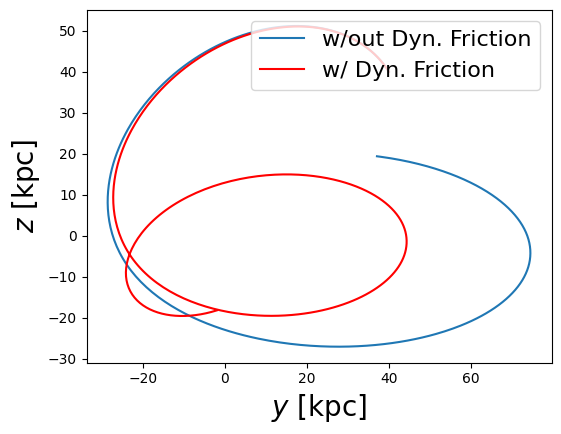

In [7]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
ax.plot(orb_no_friction.ys[:,1], orb_no_friction.ys[:,2],color='tab:blue',label='w/out Dyn. Friction')
ax.plot(orb_with_friction.ys[:,1], orb_with_friction.ys[:,2],color='r', label='w/ Dyn. Friction')
ax.legend(fontsize=16,loc='upper right')
ax.set_xlabel(r'$y$ [kpc]',fontsize=20)
ax.set_ylabel(r'$z$ [kpc]',fontsize=20)
ax.set_aspect('equal')